# Prerequisites

To run this notebook, `tensorflow` and `microfaune` need to be installed.

To train or check prediction results, the datasets *freefield* and *warblr* must be unzipped in a folder (its path is specified in the next cell).
The folder tree should look like this:
* [data_dir_path]/
  * ff1010bird_wav/
    * labels.csv
    * wav/
  * warblrb10k_public_wav/
    * labels.csv
    * wav/


ToDoS: 
       * Make sure this works with CUDA
           * Check what I should be sending to CUDA

In [1]:
train = True
fineTuning = False
datasets_dir = "/Users/mugetronblue/E4E/AcousticSpecies/passive-acoustic-biodiversity/TweetyNET/data"

# imports and function definitions

In [2]:
%matplotlib notebook
import os
import csv
import pickle
from collections import Counter
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch import nn
from torch.utils.data import DataLoader
from network import TweetyNet
import librosa
from librosa import display
from microfaune.audio import wav2spc
from glob import glob

from torch.utils.data import Dataset

In [3]:
def load_dataset(data_path, use_dump=True):
    mel_dump_file = os.path.join(data_path, "mel_dataset.pkl")
    if os.path.exists(mel_dump_file) and use_dump:
        with open(mel_dump_file, "rb") as f:
            dataset = pickle.load(f)
    else:
        dataset = compute_feature(data_path)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    inds = [i for i, x in enumerate(dataset["X"]) if x.shape[1] == 431]
    X = np.array([dataset["X"][i].transpose() for i in inds])
    Y = np.array([int(dataset["Y"][i]) for i in inds])
    uids = [dataset["uids"][i] for i in inds]
    return X, Y, uids

def compute_feature(data_path):
    print(f"Compute features for dataset {os.path.basename(data_path)}")
    labels_file = os.path.join(data_path, "labels.csv")
    print(labels_file)
    if os.path.exists(labels_file):
        with open(labels_file, "r") as f:
            reader = csv.reader(f, delimiter=',')
            labels = {}
            next(reader)  # pass fields names
            for name, _, y in reader:
                labels[name] = y
    else:
        print("Warning: no label file detected.")
        wav_files = glob(os.path.join(data_path, "wav/*.wav"))
        labels = {os.path.basename(f)[:-4]: None for f in wav_files}
    i = 1
    X = []
    Y = []
    uids = []
    for file_id, y in labels.items():
        print(f"{i:04d}/{len(labels)}: {file_id:20s}", end="\r")
        spc = wav2spc(os.path.join(data_path, "wav", f"{file_id}.wav"))
        X.append(spc)
        Y.append(y)
        uids.append(file_id)
        i += 1
    return {"uids": uids, "X": X, "Y": Y}

In [4]:
def split_dataset(X, Y, random_state=0):
    split_generator = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    ind_train, ind_test = next(split_generator.split(X, Y))
    X_train, X_test = X[ind_train, :, :], X[ind_test, :, :]
    Y_train, Y_test = Y[ind_train], Y[ind_test]
    return ind_train, ind_test

# Load dataset

In [5]:
X0, Y0, uids0 = load_dataset(os.path.join(datasets_dir, "ff1010bird_wav"))
X1, Y1, uids1 = load_dataset(os.path.join(datasets_dir, "warblrb10k_public_wav"))

print(X0.shape, X1.shape)
print(Y0.shape, Y1.shape)
print(len(uids0), len(uids1))

(7690, 431, 40) (445, 431, 40)
(7690,) (445,)
7690 445


In [6]:
X = np.concatenate([X0, X1]).astype(np.float32)/255
Y = np.concatenate([Y0, Y1])
uids = np.concatenate([uids0, uids1])

print(X.shape, Y.shape, uids.shape)

(8135, 431, 40) (8135,) (8135,)


In [7]:
show_spectrogram(X[0])

NameError: name 'show_spectrogram' is not defined

In [8]:
del X0, X1, Y0, Y1

In [9]:
Counter(Y)

Counter({0: 5848, 1: 2287})

In [10]:
ind_train, ind_test = split_dataset(X, Y)

X_train, X_test = X[ind_train, :, :, np.newaxis], X[ind_test, :, :, np.newaxis]
Y_train, Y_test = Y[ind_train], Y[ind_test]
uids_train, uids_test = uids[ind_train], uids[ind_test]
del X, Y

In [11]:
print("Training set: ", Counter(Y_train))
print("Test set: ", Counter(Y_test))

Training set:  Counter({0: 4678, 1: 1830})
Test set:  Counter({0: 1170, 1: 457})


In [27]:
X_train[0][0],  Y_train.shape

(array([[0.3862377 ],
        [0.39808834],
        [0.40524414],
        [0.39402765],
        [0.3677069 ],
        [0.37698388],
        [0.37097   ],
        [0.35567722],
        [0.36648208],
        [0.37967622],
        [0.37923044],
        [0.37732598],
        [0.38829786],
        [0.37999457],
        [0.37264475],
        [0.39069083],
        [0.36706087],
        [0.3435211 ],
        [0.32803327],
        [0.3242824 ],
        [0.33209372],
        [0.3326303 ],
        [0.3250207 ],
        [0.32903245],
        [0.32623854],
        [0.329992  ],
        [0.31481966],
        [0.3273929 ],
        [0.3328804 ],
        [0.30206603],
        [0.28751025],
        [0.28708598],
        [0.2966184 ],
        [0.29982919],
        [0.293275  ],
        [0.27247098],
        [0.26970467],
        [0.26420963],
        [0.26060724],
        [0.2702061 ]], dtype=float32),
 (6508,))

In [28]:
Y_train[1000], uids_train[1000]

(1, '95819')

In [29]:
def show_spectrogram(spec):
    fig, ax = plt.subplots()
    M_db_bird = librosa.power_to_db(spec, ref=np.max)
    img = librosa.display.specshow(M_db_bird, y_axis='mel', x_axis='time', ax=ax)
    ax.set(title='Mel spectrogram Bird0')
    plt.show()

In [30]:
X_train[0].shape

(431, 40, 1)

In [31]:
X_train.shape

(6508, 431, 40, 1)

In [32]:
Y_train[1000]

1

<IPython.core.display.Javascript object>


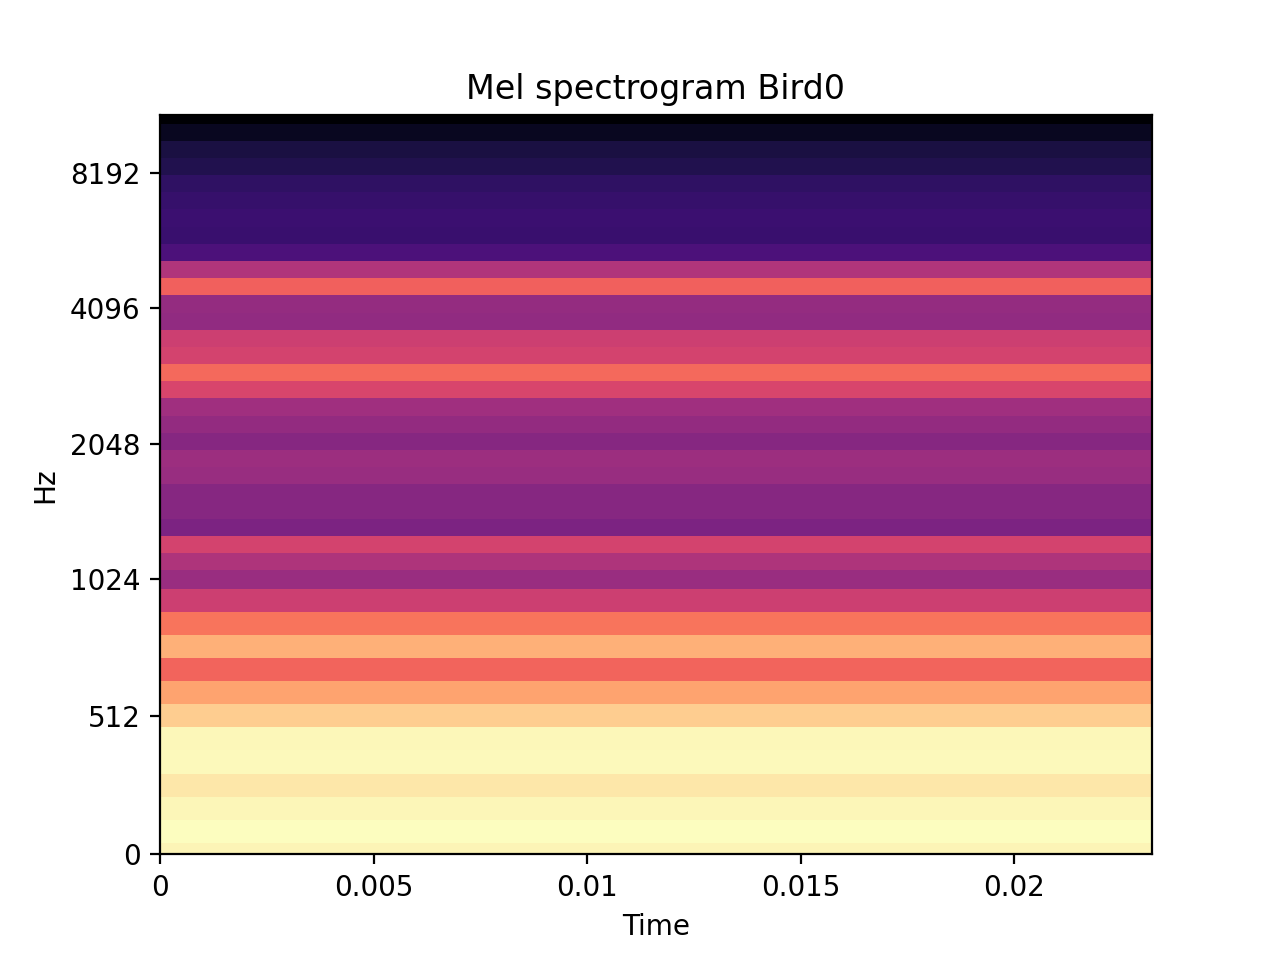

/Users/mugetronblue/opt/anaconda3/envs/species-id/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/mugetronblue/opt/anaconda3/envs/species-id/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


In [33]:
show_spectrogram(X_train[1000][0])
#look at matplotlib specgram.

In [35]:
class CustomAudioDataset(Dataset):
    def __init__(self, spec, annotations, uids, transform=None, target_transform=None):
        self.img_labels = annotations
        self.spec = spec
        self.uids = uids
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        #img_path = os.path.join(self.img_dir, self.img_labels[idx, 0])
        #Read_audio
        image = self.spec[idx]#read_image(img_path)
        label = self.img_labels[idx]
        # transform should be spectrogram from librosa # unless we do that beforehand. 
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, self.uids[idx]

In [36]:
train_dataset = CustomAudioDataset(X_train, Y_train, uids_train)
test_dataset = CustomAudioDataset(X_test, Y_test, uids_test)

# Create TweetyNet Model

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
#make the input look nicer
def CreateTweetyNet(device):
    network = TweetyNet(num_classes = 2, 
             input_shape=(431, 40, 1),
             padding='same',
             conv1_filters=32,
             conv1_kernel_size=(5, 5), 
             conv2_filters=64,
             conv2_kernel_size=(5, 5), 
             pool1_size=(8, 1), 
             pool1_stride=(8, 1), 
             pool2_size=(4, 1), 
             pool2_stride=(4, 1), 
             hidden_size=None,
             rnn_dropout=0.,
             num_layers=1
        ) 
    model = network.to(device)
    print(model)
    return model
model = CreateTweetyNet(device)

Using cpu device
TweetyNet(
  (cnn): Sequential(
    (0): Conv2dTF(431, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(8, 1), stride=(8, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2dTF(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(64, 64, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


/Users/mugetronblue/opt/anaconda3/envs/species-id/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [38]:
def reset_weights(the_model):
    for name, module in the_model.named_children():
        if hasattr(module, 'reset_parameters'):
            print('resetting ', name)
            module.reset_parameters()

In [45]:

#log_softmax = m = nn.LogSoftmax(dim=2)

#all the training works!
def training_step(model, device, train_loader, val_loader, criterion, optimizer, scheduler, epoch):
    history = {"loss": [],
               "val_loss": [],
               "acc": [],
               "val_acc": []
              }
    data_len = len(train_loader.dataset)
    for e in range(epoch):  # loop over the dataset multiple times
        model.train(True)
        running_loss = 0.0
        correct = 0.0
        for i, data in enumerate(train_loader, 0):
            scheduler.step()
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _ = data #, input_lengths, label_lengths = data
            labels = labels.reshape(labels.shape[0],1)
            # zero the parameter gradients
            print(inputs.shape, labels.shape)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            output = model(inputs, len(inputs), len(labels))
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # get statistics
            running_loss += loss.item()
            output = torch.argmax(output, dim = 1)
            correct += (output == labels).float().sum()
            
            # print update
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        history["loss"].append(running_loss)
        history["acc"].append(100 * correct/ len(train_loader.dataset))
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_correct = 0.0
            for i, data in enumerate(val_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels, _ = data #, input_lengths, label_lengths = data
                print(inputs.shape, labels.shape)
                labels = labels.reshape(labels.shape[0],1)

                output = model(inputs, len(inputs), len(labels)) 
                loss = criterion(output, labels)

                # get statistics
                val_loss += loss.item()
                output = torch.argmax(output, dim = 1)
                val_correct += (output == labels).float().sum()
            history["val_loss"].append(val_loss)
            history["val_acc"].append(100 * val_correct/len(val_loader.dataset))
    print('Finished Training')
    return history

def testing_step(model, device, test_loader):
    predictions = pd.DataFrame()
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels, uids = data
            labels = labels.reshape(labels.shape[0],1)
            uids = np.array([u for u in uids])
            output = model(inputs, len(inputs), len(labels)) 
            output = torch.argmax(output, dim = 1)
            d = {"uid" : uids.flatten(), "pred" : output.flatten(), "label": labels.flatten()}
            new_preds = pd.DataFrame(d)
            predictions = predictions.append(new_preds)
    print('Finished Testing')
    return predictions

In [46]:
alpha = 0.4    
batch_size = 64
lr = .005
epochs = 20

if train:
    if fineTuning:
        model.load_weights("model_weights-20190919_220113.h5")
    model = CreateTweetyNet(device)
    model.train()
    
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    criterion = torch.nn.CrossEntropyLoss().to(device)

    optimizer = torch.optim.Adam(params=model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                        max_lr=lr,
                        steps_per_epoch=int(len(train_data_loader)),
                        epochs=epochs,
                        anneal_strategy='linear')
    
    #Can implement when we actually start training the model
    #es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    #mc = keras.callbacks.ModelCheckpoint(filepath='best_model_weights.h5', save_weights_only=True, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    #reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
    #                              patience=5, min_lr=1e-5)
    new_history = training_step(model, device, train_data_loader, val_data_loader, criterion, optimizer, scheduler, epochs)
    """
    history = model.fit_generator(data_generator, steps_per_epoch=5, epochs=100, 
                                  validation_data=(X_test, Y_test),
                                  class_weight={0: alpha, 1: 1-alpha},
                                  callbacks=[es,mc,reduce_lr], verbose=1) #origin steps_per_epoch=100, epochs=100

    """
    history = new_history
    date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    #model.save_weights(f"model_weights-{date_str}.h5")
    

TweetyNet(
  (cnn): Sequential(
    (0): Conv2dTF(431, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(8, 1), stride=(8, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2dTF(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(64, 64, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
torch.Size([64, 431, 40, 1]) torch.Size([64, 1])
torch.Size([64, 431, 40, 1]) torch.Size([64, 1])
torch.Size([64, 431, 40, 1]) torch.Size([64, 1])
torch.Size([64, 431, 40, 1]) torch.Size([64, 1])
torch.Size([64, 431, 40, 1]) torch.Size([64, 1])
torch.Size([64, 431, 40, 1]) torch.Size([64, 1])
torch.Size([64, 431, 40, 1]) torch.Size([64, 1])
torch.Size([64, 431, 40, 1]) torch.Size([64, 1])
torch.Size([64, 431, 40, 1]) torch.Size([64, 1])
torch.Size([64, 431, 40, 

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), f"model_weights-{date_str}.h5")

In [ ]:
print(history)

In [ ]:
if train:
    plt.figure(figsize=(9, 6))
    plt.title("Loss")
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])
    plt.legend(["loss", "val_loss"])
    plt.savefig('loss.png')
    
    plt.figure(figsize=(9, 6))
    plt.title("Accuracy")
    plt.plot(history["acc"])
    plt.plot(history["val_acc"])
    plt.legend(["acc", "val_acc"])
    plt.savefig('acc.png')

# Results

## tOdOs:
    * work on reading in test data
    * loading in weights
    * Get Basic metrics, precision, recall, accuracy
    * getting roc curves and precision vs. recall curves. 

In [ ]:
len(val_data_loader.dataset)

In [ ]:
testing_step(model, device, val_data_loader)

## Load model

In [ ]:
import IPython.display as ipd

from sklearn.metrics import roc_curve, auc

from microfaune.audio import load_wav
import librosa.display

In [ ]:
if not train:
    #model.load_weights("model_weights-20190919_220113.h5")
    #model.load_weights("model_weights-20200526_083126.h5")
    model.load_state_dict(torch.load("PATH"))
    model.eval()

In [ ]:
wav_files = {os.path.basename(f)[:-4]: f for f in glob(os.path.join(datasets_dir, "*/wav/*.wav"))}

## Evaluation on validation dataset

In [ ]:
%%time
scores, local_scores = dual_model.predict(X_test)

In [ ]:
Y_hat = scores.squeeze() > 0.5
print(f"Accuracy: {np.mean(Y_hat == Y_test)*100:.2f}")

In [ ]:
fpr, tpr, sc = roc_curve(Y_test, scores)
print(f"Area under ROC curve: {auc(fpr, tpr):f}")

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(1-fpr, tpr)
plt.title("Precision/Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.savefig("imgs/PR_curve.png")

In [ ]:
success = np.where(Y_hat == Y_test)[0]
errors = np.where(Y_hat != Y_test)[0]

In [ ]:
def check_result(uid, x, y, pred_score, y_hat_time, wav_files=wav_files):
    wav_file = wav_files[uid]
    sr, audio = load_wav(wav_file)
    plt.figure(figsize=(9, 6))
    label_dict = {0: "Negative", 1: "Positive"}
    plt.suptitle(f"UID: '{uid}', {label_dict[y]} example, predicted score: {pred_score[0]:.2f}")

    plt.subplot(3, 1, 1)
    plt.title("Audio wave")
    librosa.display.waveplot(audio, sr)

    plt.subplot(3, 1, 2)
    plt.title("MEL spectrogram")
    librosa.display.specshow(np.rot90(x.squeeze(), -1))

    plt.subplot(3, 1, 3)
    plt.title("Local prediction")
    ax = plt.gca()
    ax.set_xlim(0, x.shape[0])
    ax.set_ylim(-0.05, 1.05)
    plt.plot(y_hat_time)
    return ipd.Audio(wav_file)
    

## success

In [ ]:
ind = success[2]
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

In [ ]:
ind = success[]
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/positive_success.png")
reader

In [ ]:
ind = success[15]
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

In [ ]:
ind = success[99]
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

In [ ]:
ind = 89
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/negative_success.png")
reader

In [ ]:
ind = 565
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

## errors

In [ ]:
ind = errors[1]
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/negative_error.png")
reader

In [ ]:
ind = errors[5]
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/positive_error.png")
reader

## labelling errors?

In [ ]:
ind = errors[12]
check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])

In [ ]:
# false error
ind = 105
reader = check_result(uids_test[ind], X_test[ind], Y_test[ind], scores[ind], local_scores[ind, :])
plt.savefig("imgs/labelling_error.png")
reader

## Test on other datasets

### BirdVox